Shahar Michaeli - 316535608

In [1]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_recall_fscore_support,balanced_accuracy_score


In [2]:
image_normalize = lambda x : x / 255.
one_hot = lambda t : nn.functional.one_hot(t)

In [3]:
train_dataset = datasets.MNIST('/files/',train=True,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(image_normalize)]))
test_dataset = datasets.MNIST('/files/',train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(image_normalize)]))

train_length = int(0.9*len(train_dataset))
val_length = int(0.1*len(train_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_length, val_length])

In [6]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=50,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=50,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=50,shuffle=True)

datasets_with_types = [("Train Dataset",train_loader),("Validation Dataset",val_loader),("Test Dataset",test_loader)]

In [7]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
def init_conv2d_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        m.weight = nn.Parameter(torch.abs(m.weight))
        m.bias.data.fill_(0.01)

In [8]:
def train(model,loss,optimizer):
  model.to(device)
  model.train()

  num_epochs = 20
  total_batches = 0
  MAX_BATCHES = 13000

  start = time.time()
  for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      cross_entropy = loss(model(images), labels)
      optimizer.zero_grad()
      cross_entropy.backward()
      optimizer.step()

      if not (total_batches % 1000):
        print(f"Batch Number : {total_batches}, Loss : {cross_entropy.item()}")
      
      if total_batches == MAX_BATCHES:
        end = time.time()
        total_weights = sum([p.numel() for p in model.parameters()])
        print(f"Total Train Time : {round(end-start,2)} s , Network Total Weights : {total_weights}")
        return 
      total_batches+=1


In [9]:
def predict(model,dataloader):
  model.eval()
  loss = torch.nn.CrossEntropyLoss()
  y_pred = torch.tensor([], device=device)
  y_true = torch.tensor([], dtype=torch.long, device=device)

  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(dataloader):
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      y_pred = torch.cat((y_pred, torch.argmax(output,1)), 0)
      y_true = torch.cat((y_true, labels), 0)
      
  return y_pred,y_true

In [10]:
def accuracy_calculate(y_pred,y_true):
  accuracy = torch.mean((y_pred == y_true).type(torch.float32))
  return accuracy

def balanced_accuracy_calculate(y_true, y_pred):
  return balanced_accuracy_score(y_true, y_pred)

In [11]:
def print_metrics(type_name, y_pred, y_true):
  torch.set_printoptions(precision=2)
  precision,recall,fscore,_ = precision_recall_fscore_support(y_pred=y_pred,y_true=y_true,average=None)
  # accuracy = torch.mean((y_pred == y_true).type(torch.float32))
  acc = [0 for c in range(10)]
  for c in range(10):
      acc[c] = float(((y_pred == y_true) * (y_true == c)).type(torch.float32).sum() / (y_true == c).type(torch.float32).sum())

  print(f"Dataset Type : {type_name}")
  print(f"FScore : [{','.join([str(round(x,2)) for x in fscore])}]")
  print(f"Precision : [{','.join([str(round(x,2)) for x in precision])}]")
  print(f"Recall : [{','.join([str(round(x,2)) for x in recall])}]")
  print(f"Accuracy : [{','.join([str(round(x,2)) for x in acc])}]")
  print()

In [12]:
class PlotLayer(nn.Module):
    def __init__(self):
        super(PlotLayer, self).__init__()
        self.i = 1
        self.visualization = False
    def forward(self, x):
      if self.visualization:
        if self.i == 1:
          plt.subplot(1, 6, self.i).set_title('Original Image')
        else:
          plt.subplot(1, 6, self.i).set_title(str(self.i))
        self.i+= 1
        plt.imshow(x.detach().numpy()[0][0])
      return x

In [13]:
plot_layer = PlotLayer()

# Model 1 - Logistic Regression without Hidden Layers

In [ ]:
lr=0.01
loss = torch.nn.CrossEntropyLoss()
LR_Model_No_HL = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
)
optimizer = torch.optim.Adam(LR_Model_No_HL.parameters(), lr=lr)

In [ ]:
train(LR_Model_No_HL,loss,optimizer)

Batch Number : 0, Loss : 2.3040242195129395
Batch Number : 1000, Loss : 1.3354681730270386
Batch Number : 2000, Loss : 0.8204839825630188
Batch Number : 3000, Loss : 0.7713116407394409
Batch Number : 4000, Loss : 0.475637823343277
Batch Number : 5000, Loss : 0.5292565822601318
Batch Number : 6000, Loss : 0.2914387881755829
Batch Number : 7000, Loss : 0.4854883551597595
Batch Number : 8000, Loss : 0.3794262409210205
Batch Number : 9000, Loss : 0.32263630628585815
Batch Number : 10000, Loss : 0.4870041012763977
Batch Number : 11000, Loss : 0.43241211771965027
Batch Number : 12000, Loss : 0.3422311544418335
Batch Number : 13000, Loss : 0.44603997468948364
Total Train Time : 119.21 s , Network Total Weights : 7850


In [ ]:
for dataset_type,dataloader in datasets_with_types:
  y_pred, y_true = predict(LR_Model_No_HL,dataloader)
  print_metrics(dataset_type,y_pred.cpu(), y_true.cpu())


Dataset Type : Train Dataset
FScore : [0.95,0.94,0.88,0.87,0.91,0.85,0.94,0.92,0.85,0.87]
Precision : [0.95,0.92,0.91,0.87,0.9,0.86,0.92,0.92,0.86,0.87]
Recall : [0.96,0.96,0.86,0.87,0.92,0.84,0.95,0.91,0.85,0.88]
Accuracy : [0.96,0.96,0.86,0.87,0.92,0.84,0.95,0.91,0.85,0.88]

Dataset Type : Validation Dataset
FScore : [0.96,0.93,0.88,0.88,0.89,0.85,0.93,0.91,0.85,0.87]
Precision : [0.95,0.91,0.9,0.88,0.88,0.87,0.92,0.93,0.85,0.86]
Recall : [0.97,0.96,0.86,0.88,0.9,0.84,0.94,0.89,0.86,0.87]
Accuracy : [0.97,0.96,0.86,0.88,0.9,0.84,0.94,0.89,0.86,0.87]

Dataset Type : Test Dataset
FScore : [0.96,0.95,0.89,0.89,0.91,0.86,0.93,0.91,0.86,0.88]
Precision : [0.94,0.94,0.93,0.88,0.9,0.88,0.92,0.92,0.86,0.88]
Recall : [0.98,0.96,0.86,0.9,0.92,0.84,0.94,0.9,0.87,0.88]
Accuracy : [0.98,0.96,0.86,0.9,0.92,0.84,0.94,0.9,0.87,0.88]



# Logistic Regression with Two Fully Connected 

In [14]:
lr=0.01
loss = torch.nn.CrossEntropyLoss()
LR_Model_TWO_FC = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
optimizer = torch.optim.Adam(LR_Model_TWO_FC.parameters(), lr=lr)


In [15]:
train(LR_Model_TWO_FC,loss,optimizer)

Batch Number : 0, Loss : 2.3113183975219727
Batch Number : 1000, Loss : 0.10337057709693909
Batch Number : 2000, Loss : 0.06197874993085861
Batch Number : 3000, Loss : 0.031527310609817505
Batch Number : 4000, Loss : 0.11984220147132874
Batch Number : 5000, Loss : 0.14444397389888763
Batch Number : 6000, Loss : 0.04891185835003853
Batch Number : 7000, Loss : 0.10898006707429886
Batch Number : 8000, Loss : 0.019743192940950394
Batch Number : 9000, Loss : 0.15977200865745544
Batch Number : 10000, Loss : 0.11724363267421722
Batch Number : 11000, Loss : 0.018491683527827263
Batch Number : 12000, Loss : 0.03921430930495262
Batch Number : 13000, Loss : 0.03627786785364151
Total Train Time : 130.65 s , Network Total Weights : 199210


In [16]:
for dataset_type,dataloader in datasets_with_types:
  y_pred, y_true = predict(LR_Model_TWO_FC,dataloader)
  print_metrics(dataset_type,y_pred.cpu(), y_true.cpu())

Dataset Type : Train Dataset
FScore : [0.99,0.99,0.99,0.98,0.99,0.98,0.99,0.99,0.98,0.98]
Precision : [1.0,0.99,0.99,0.99,0.99,0.99,0.98,0.99,0.97,0.98]
Recall : [0.99,1.0,0.98,0.97,0.99,0.98,1.0,0.98,0.99,0.99]
Accuracy : [0.99,1.0,0.98,0.97,0.99,0.98,1.0,0.98,0.99,0.99]

Dataset Type : Validation Dataset
FScore : [0.98,0.99,0.97,0.98,0.97,0.96,0.98,0.98,0.96,0.96]
Precision : [0.98,0.99,0.98,0.99,0.97,0.97,0.97,0.99,0.95,0.95]
Recall : [0.97,0.99,0.97,0.96,0.97,0.96,0.99,0.97,0.98,0.97]
Accuracy : [0.97,0.99,0.97,0.96,0.97,0.96,0.99,0.97,0.98,0.97]

Dataset Type : Test Dataset
FScore : [0.98,0.99,0.97,0.98,0.98,0.97,0.98,0.97,0.97,0.97]
Precision : [0.98,0.98,0.98,0.98,0.98,0.98,0.97,0.98,0.95,0.95]
Recall : [0.98,0.99,0.96,0.97,0.97,0.96,0.98,0.96,0.98,0.98]
Accuracy : [0.98,0.99,0.96,0.97,0.97,0.96,0.98,0.96,0.98,0.98]



# Model 3

In [ ]:
lr = 1e-3
loss = torch.nn.CrossEntropyLoss()
model3 = nn.Sequential(
    plot_layer,
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    plot_layer,
    nn.ReLU(),
    plot_layer,
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=32*14*14, out_features=1024),
    nn.ReLU(),    
    nn.Linear(in_features=1024, out_features=10)
)

model3.apply(init_conv2d_weights)
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)


In [ ]:
train(model3,loss,optimizer)

Batch Number : 0, Loss : 2.301623582839966
Batch Number : 1000, Loss : 0.2716485261917114
Batch Number : 2000, Loss : 0.1759038120508194
Batch Number : 3000, Loss : 0.04234032332897186
Batch Number : 4000, Loss : 0.15155144035816193
Batch Number : 5000, Loss : 0.07644286751747131
Batch Number : 6000, Loss : 0.0798410102725029
Batch Number : 7000, Loss : 0.0723567083477974
Batch Number : 8000, Loss : 0.03467173874378204
Batch Number : 9000, Loss : 0.08411362022161484
Batch Number : 10000, Loss : 0.022686569020152092
Batch Number : 11000, Loss : 0.013663121499121189
Batch Number : 12000, Loss : 0.006086504086852074
Batch Number : 13000, Loss : 0.07548071444034576
Total Train Time : 138.06 s , Network Total Weights : 6434634


In [ ]:
for dataset_type,dataloader in datasets_with_types:
  y_pred, y_true = predict(model3,dataloader)
  print_metrics(dataset_type,y_pred.cpu(), y_true.cpu())

Dataset Type : Train Dataset
FScore : [0.99,0.99,0.99,0.98,0.99,0.99,0.99,0.99,0.98,0.98]
Precision : [0.98,1.0,0.99,0.99,0.99,0.99,1.0,0.99,0.98,0.96]
Recall : [1.0,0.99,0.99,0.98,0.98,0.98,0.99,0.99,0.99,0.99]
Accuracy : [1.0,0.99,0.99,0.98,0.98,0.98,0.99,0.99,0.99,0.99]

Dataset Type : Validation Dataset
FScore : [0.99,0.98,0.98,0.98,0.97,0.97,0.98,0.97,0.96,0.96]
Precision : [0.98,0.99,0.98,0.98,0.99,0.98,0.98,0.96,0.95,0.94]
Recall : [0.99,0.97,0.98,0.97,0.95,0.95,0.97,0.98,0.98,0.97]
Accuracy : [0.99,0.97,0.98,0.97,0.95,0.95,0.97,0.98,0.98,0.97]

Dataset Type : Test Dataset
FScore : [0.98,0.99,0.98,0.97,0.97,0.98,0.98,0.98,0.97,0.96]
Precision : [0.97,0.99,0.98,0.97,0.98,0.99,0.99,0.98,0.97,0.95]
Recall : [0.99,0.99,0.97,0.98,0.96,0.97,0.97,0.98,0.97,0.98]
Accuracy : [0.99,0.99,0.97,0.98,0.96,0.97,0.97,0.98,0.97,0.98]



# Model 4

In [ ]:
lr = 1e-3
loss = torch.nn.CrossEntropyLoss()
model4 = nn.Sequential(
    plot_layer,
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    plot_layer,
    nn.ReLU(),
    plot_layer,
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'),
    plot_layer,
    nn.ReLU(),
    plot_layer,
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

    nn.Flatten(),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),    
    nn.Linear(in_features=1024, out_features=10)
)

model4.apply(init_conv2d_weights)
optimizer = torch.optim.Adam(model4.parameters(), lr=lr)


In [ ]:
train(model4,loss,optimizer)

Batch Number : 0, Loss : 2.296264886856079
Batch Number : 1000, Loss : 0.36799976229667664
Batch Number : 2000, Loss : 0.18927067518234253
Batch Number : 3000, Loss : 0.14405548572540283
Batch Number : 4000, Loss : 0.022595949470996857
Batch Number : 5000, Loss : 0.015352425165474415
Batch Number : 6000, Loss : 0.1718735694885254
Batch Number : 7000, Loss : 0.04539993777871132
Batch Number : 8000, Loss : 0.007791819516569376
Batch Number : 9000, Loss : 0.007204375695437193
Batch Number : 10000, Loss : 0.02481054700911045
Batch Number : 11000, Loss : 0.002093401737511158
Batch Number : 12000, Loss : 0.008901005610823631
Batch Number : 13000, Loss : 0.07396607846021652
Total Train Time : 148.68 s , Network Total Weights : 3274634


In [ ]:
for dataset_type,dataloader in datasets_with_types:
  y_pred, y_true = predict(model4,dataloader)
  print_metrics(dataset_type,y_pred.cpu(), y_true.cpu())

Dataset Type : Train Dataset
FScore : [1.0,1.0,0.99,1.0,1.0,1.0,0.99,1.0,1.0,1.0]
Precision : [1.0,1.0,1.0,0.99,1.0,1.0,0.99,1.0,1.0,0.99]
Recall : [1.0,1.0,0.99,1.0,1.0,1.0,1.0,1.0,0.99,1.0]
Accuracy : [1.0,1.0,0.99,1.0,1.0,1.0,1.0,1.0,0.99,1.0]

Dataset Type : Validation Dataset
FScore : [0.99,0.99,0.99,0.99,0.98,0.98,0.99,0.98,0.98,0.98]
Precision : [1.0,0.99,1.0,0.98,0.98,0.99,0.98,0.98,0.98,0.98]
Recall : [0.99,0.99,0.98,0.99,0.98,0.97,0.99,0.98,0.98,0.98]
Accuracy : [0.99,0.99,0.98,0.99,0.98,0.97,0.99,0.98,0.98,0.98]

Dataset Type : Test Dataset
FScore : [0.99,0.99,0.98,0.98,0.99,0.98,0.99,0.99,0.98,0.98]
Precision : [0.99,0.99,1.0,0.97,0.99,0.99,0.98,0.99,0.98,0.98]
Recall : [0.99,0.99,0.97,1.0,0.99,0.98,0.99,0.99,0.98,0.99]
Accuracy : [0.99,0.99,0.97,1.0,0.99,0.98,0.99,0.99,0.98,0.99]



# Model 5 - Model 4 with Dropout

In [ ]:
lr = 1e-3
loss = torch.nn.CrossEntropyLoss()
model5 = nn.Sequential(
    plot_layer,
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    plot_layer,
    nn.ReLU(),
    plot_layer,
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'),
    plot_layer,
    nn.ReLU(),
    plot_layer,
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

    nn.Flatten(),
    nn.Dropout(p=0.5),

    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),    
    nn.Linear(in_features=1024, out_features=10)
)

model5.apply(init_conv2d_weights)
optimizer = torch.optim.Adam(model5.parameters(), lr=lr)


In [ ]:
train(model5,loss,optimizer)

Batch Number : 0, Loss : 2.310124397277832
Batch Number : 1000, Loss : 0.2537778913974762
Batch Number : 2000, Loss : 0.2574329674243927
Batch Number : 3000, Loss : 0.05577714741230011
Batch Number : 4000, Loss : 0.09620154649019241
Batch Number : 5000, Loss : 0.0058939289301633835
Batch Number : 6000, Loss : 0.03544905409216881
Batch Number : 7000, Loss : 0.008007063530385494
Batch Number : 8000, Loss : 0.0020559041295200586
Batch Number : 9000, Loss : 0.024519462138414383
Batch Number : 10000, Loss : 0.04223504662513733
Batch Number : 11000, Loss : 0.022084617987275124
Batch Number : 12000, Loss : 0.002272689715027809
Batch Number : 13000, Loss : 0.002974939066916704
Total Train Time : 145.77 s , Network Total Weights : 3274634


In [ ]:
for dataset_type,dataloader in datasets_with_types:
  y_pred, y_true = predict(model5,dataloader)
  print_metrics(dataset_type,y_pred.cpu(), y_true.cpu())

Dataset Type : Train Dataset
FScore : [1.0,1.0,1.0,0.99,1.0,0.99,1.0,1.0,0.99,0.99]
Precision : [1.0,1.0,1.0,1.0,0.99,0.99,0.99,0.99,1.0,0.99]
Recall : [1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,0.99,0.99]
Accuracy : [1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,0.99,0.99]

Dataset Type : Validation Dataset
FScore : [0.99,0.99,0.99,0.99,0.98,0.98,0.99,0.99,0.98,0.98]
Precision : [0.99,0.99,0.99,1.0,0.98,0.98,0.99,0.98,0.97,0.98]
Recall : [0.99,0.99,0.99,0.98,0.98,0.98,1.0,0.99,0.98,0.97]
Accuracy : [0.99,0.99,0.99,0.98,0.98,0.98,1.0,0.99,0.98,0.97]

Dataset Type : Test Dataset
FScore : [0.99,1.0,0.99,0.99,0.99,0.98,0.99,0.99,0.99,0.98]
Precision : [0.99,0.99,0.99,1.0,0.99,0.98,0.99,0.99,0.99,0.98]
Recall : [1.0,1.0,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.98]
Accuracy : [1.0,1.0,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.98]



# Compare Batch Size for Model 5 

In [ ]:
def train_compare(model,loss,optimizer,train_set, val_set,batch_size):
  model.to(device)
  model.train()
  traindata_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  validationdata_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=True)

  total_epochs = 0
  total_batches = 0
  acc = 0
  start = time.time()
  while True:
    for batch_idx, (images, labels) in enumerate(traindata_loader):
      images, labels = images.to(device), labels.to(device)
      cross_entropy = loss(model(images), labels)
      optimizer.zero_grad()
      cross_entropy.backward()
      optimizer.step()
      if not (total_batches % 1000):
        print(f"Batch Number : {total_batches}, Loss : {cross_entropy.item()}")
      total_batches += 1

    y_pred,y_true = predict(model,validationdata_loader)
    acc = accuracy_calculate(y_pred,y_true)
    if not total_epochs % 3 :
      print(f"Epoch Number : {total_epochs}, Loss : {cross_entropy.item()}, Validation Accuracy : {acc}")
      
    if acc >= 0.99:
      end = time.time()
      print(f"Total Train Time : {round(end-start,2)} s , Total epochs: {total_epochs}")
      return 
    model.train()
    total_epochs+=1


In [ ]:
loss = torch.nn.CrossEntropyLoss()
model5.apply(weight_reset)
model5.apply(init_conv2d_weights)
optimizer = torch.optim.Adam(model5.parameters(), lr=lr)
train_compare(model5,loss,optimizer,train_set, val_set,50)

Batch Number : 0, Loss : 2.309506416320801
Batch Number : 1000, Loss : 0.4521767497062683
Epoch Number : 0, Loss : 0.16988033056259155, Validation Accuracy : 0.9351666569709778
Batch Number : 2000, Loss : 0.07275057584047318
Batch Number : 3000, Loss : 0.18077000975608826
Batch Number : 4000, Loss : 0.18805862963199615
Epoch Number : 3, Loss : 0.048982106149196625, Validation Accuracy : 0.9743333458900452
Batch Number : 5000, Loss : 0.06445219367742538
Batch Number : 6000, Loss : 0.025923505425453186
Batch Number : 7000, Loss : 0.022461825981736183
Epoch Number : 6, Loss : 0.08789892494678497, Validation Accuracy : 0.9783332943916321
Batch Number : 8000, Loss : 0.008389933034777641
Batch Number : 9000, Loss : 0.013502515852451324
Batch Number : 10000, Loss : 0.020590072497725487
Epoch Number : 9, Loss : 0.042828354984521866, Validation Accuracy : 0.9836666584014893
Batch Number : 11000, Loss : 0.04754165560007095
Batch Number : 12000, Loss : 0.0040259282104671
Batch Number : 13000, Los

In [ ]:
loss = torch.nn.CrossEntropyLoss()
model5.apply(weight_reset)
model5.apply(init_conv2d_weights)
optimizer = torch.optim.Adam(model5.parameters(), lr=lr)
train_compare(model5,loss,optimizer,train_set, val_set,100)

Batch Number : 0, Loss : 2.3100438117980957
Epoch Number : 0, Loss : 0.3581419885158539, Validation Accuracy : 0.8978333473205566
Batch Number : 1000, Loss : 0.23664642870426178
Batch Number : 2000, Loss : 0.10486261546611786
Epoch Number : 3, Loss : 0.06448645889759064, Validation Accuracy : 0.9713333249092102
Batch Number : 3000, Loss : 0.05569303035736084
Epoch Number : 6, Loss : 0.14642764627933502, Validation Accuracy : 0.9810000061988831
Batch Number : 4000, Loss : 0.03412346914410591
Batch Number : 5000, Loss : 0.1053718626499176
Epoch Number : 9, Loss : 0.018924398347735405, Validation Accuracy : 0.9848333597183228
Batch Number : 6000, Loss : 0.12247814983129501
Batch Number : 7000, Loss : 0.010565290227532387
Epoch Number : 12, Loss : 0.03415009379386902, Validation Accuracy : 0.9854999780654907
Batch Number : 8000, Loss : 0.01834968291223049
Epoch Number : 15, Loss : 0.01878383941948414, Validation Accuracy : 0.9858333468437195
Batch Number : 9000, Loss : 0.05159076675772667


# Final Results - Visualization - Best Architecture

## Find Best Model with the best Balanced Accuracy

In [ ]:
models = [model5,model4,model3,LR_Model_No_HL,LR_Model_TWO_FC]
models_name = ['Model 5','Model 4', 'Model 3', 'Model 2', 'Model 1']
best_model = None
best_bc = 0
best_model_name = None
for model,model_name in zip(models,models_name):
  y_pred, y_true = predict(model,val_loader)
  bc = balanced_accuracy_calculate(y_true.cpu(), y_pred.cpu())
  print(f"Model {model_name} : {bc}")
  if bc > best_bc:
    best_model = model
    best_bc = bc
    best_model_name = model_name

print(f"Best Model {best_model_name} : {best_bc}")

Model Model 5 : 0.9859828200224754
Model Model 4 : 0.9844140687521111
Model Model 3 : 0.9725012246587431
Model Model 2 : 0.8955955960309414
Model Model 1 : 0.9681822280561121
Best Model Model 5 : 0.9859828200224754


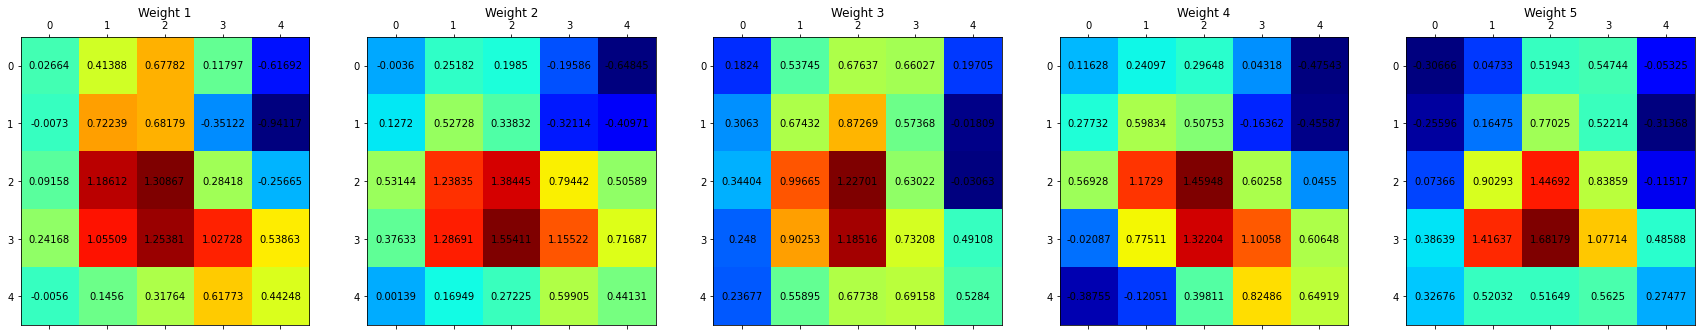

In [ ]:
fig, ax = plt.subplots(1,5,figsize=(30,35))
for index in range(5):

  intersection_matrix = best_model[1].weight.detach()[index][0]
  ax[index].set_title(f'Weight {index+1}')
  ax[index].matshow(intersection_matrix.cpu(), cmap='jet')

  for i in range(5):
      for j in range(5):
          c = intersection_matrix[j,i]
          ax[index].text(i, j, round(float(c),5), va='center', ha='center')


## Visualization of the Convolution
Visualization of image process in two convolution layers of the best architecture, before and after the ReLU.

tensor([[ -5.24,  -4.58,  -4.76,  -6.49,  -6.91,  -2.61,  -7.17, -11.65,  10.99,
          -3.90]], grad_fn=<AddmmBackward0>)

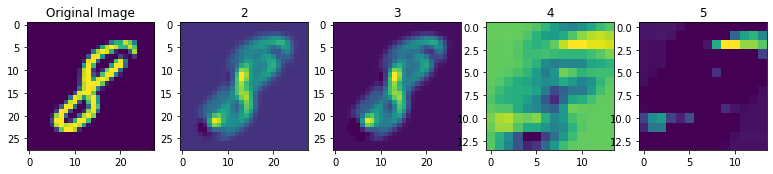

In [ ]:
best_model.cpu()
best_model.eval()
plot_layer.visualization = True
plt.figure(figsize=(16,16))
x, _ = train_dataset[7777] 
best_model(x[[np.newaxis,...]])
  